<a href="https://colab.research.google.com/github/mrenrique/projects/blob/main/posts/predicting-wild-blueberry-yield-using-supervised-ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

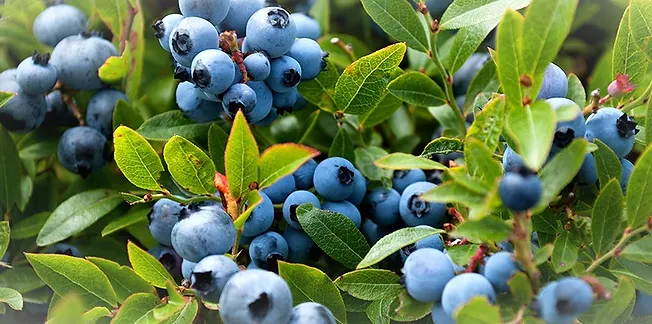

## TL;DR 🤓

In this project, I went through many steps to accomplish the main goal: Build a ML Model to predict how much of **Wild Blueberry** will it **yield** based on the combinations of some features. I trained & evaluate **06 ML Algorithms** for this task: `Ridge, LinearRegression, SVR, DecisionTreeRegressor, RandomForestRegressor, XGBRegressor` . In the end, the chosen one which provided the best results was `RandomForestRegressor`.

There was not much to do in terms of pre-processing since all features were numerical. I just check for **missing values & Outliers** to validate it's a **tidy dataset**.

Next, I make some **Exploratory Data Analysis** to understand a bit more about the target (univariable Analysis) and the relation with its features (multivariable Analysis).

Then, I standarize by scaling all features in order to surpress the impact of values with high magnitude.

After all this, I split the data and trained the 06 models. Then, I use **k-fold cross validation** to compared them out to find out wich on gives better results. At the end, **XGBRegressor** ended up being the best model, so I try to enhance it by finding the best params combination, I included them and fit it for the last time.

Finally, I use the trained model on the test data provided and save its predictions. I also save the model to reuse it later. For explainability purpose, I plot a bar chart to show the **ranking of the most important features** for the model and its yield prediction.

Happy learning! 😊

## Problem Undestanding ❓

### What’s the problem? 🤔

The goal is to train a model that can **predict Wild Blueberry Yield**, This, will return how much yield is expected based on certain attributes that might influence it. Since the Amount of Wild Blueberry to be yielded is a **continuous variable**, we are dealing with a **Regression Problem**.

Data columns:

- Clonesize m2: average blueberry clone size in the field
- Honeybee bees/m2/min: Honeybee density in the field
- Bumbles bees/m2/min: Bumblebee density in the field
- Andrena bees/m2/min: Andrena bee density in the field
- Osmia bees/m2/min: Osmia bee density in the field
- MaxOfUpperTRange ℃: highest record of the upper band daily air temperature during the bloom season
- MinOfUpperTRange ℃: lowest record of the upper band daily air temperature
- AverageOfUpperTRange ℃: average of the upper band daily air temperature
- MaxOfLowerTRange ℃: highest record of the lower band daily air temperature
- MinOfLowerTRange ℃: lowest record of the lower band daily air temperature
- AverageOfLowerTRange ℃: average of the lower band daily air temperature
- RainingDays Day: total number of days during the bloom season, each of which has precipitation larger than zero
- AverageRainingDays Day: average of raining days of the entire bloom season

### What & How to measure KPI? 🎯

**R-Squared (R² or the coefficient of determination)** is the choosen metric for evaluating how good the model is at predicting Wild Blueberry Yield. But I also used Mean Squared Error & Root Mean Squared Error for comparison purpuses.

> **R^2 score** shows how well terms (data points) fit a curve or line. R^2 is a statistical measure between 0 and 1 which calculates how similar a regression line is to the data it’s fitted to.





## Setting Things Up ⚙

### Importing Libraries 🧰

Here it's imported all the libraries requiered for each process of the project.

In [ ]:
# basic libraries
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns

# For Identifing Outliers
from scipy import stats

# For Identifing Correlation Coefficient & P-value
from scipy.stats import pearsonr

# To Check Missing Values
import missingno as msno

# To avoi warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# For Data Engineering
from sklearn.preprocessing import StandardScaler

# For Splitting data
from sklearn.model_selection import train_test_split

In [ ]:
# For Building Predicting Models
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
# For Evaluating Predictive Models Using Metrics
from sklearn.metrics import mean_squared_error, r2_score

# For Optimizing any Model by Finding the Best Hyperparameters
from sklearn.model_selection import GridSearchCV

# For Evaluating Predictive Models By Using K-Fold Cross Validation
from sklearn.model_selection import cross_val_score, KFold

# For Saving the model
import joblib

### Customized Settings 🎨

Bellow, there is a function that customizes some of the default graph parameters to make them look a bit cleaner and easy to digest.

In [ ]:
g=''

def ChartWithCustomSettings(graph=g, figW=6, figH=4, title='Title'):
    graph.figure.set_figwidth(figW)
    graph.figure.set_figheight(figH)

    sns.set_theme(style='white', palette='blend:#464196,#d9d9d9')
    sns.despine() #left=True
    g.set(ylabel=None)
    plt.title(title, pad=15)

This chunk of code just show a pallet with the colors used in this projec's graphs

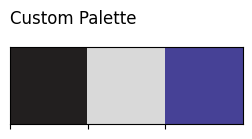

In [ ]:
sns.palplot(['#221f1f', '#d9d9d9', '#464196'])
plt.title('Custom Palette', loc='left', fontfamily='Sans Serif', fontsize=12, y=1.2)
plt.show()

## Extract & Load Data 🗃️

Here you can find the Dataset used in this project: https://www.kaggle.com/competitions/playground-series-s3e14/overview

The dataset came in two files containing Training and Test Data

In [ ]:
# Loading Training and Test Data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.head(3)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760


## Data Pre-processing 🧼

### Checking For Missing Values

Let's first check the number of Missing Values for each feature

In [ ]:
# Show Total Missing Values in Percentage Format
train_data.isnull().sum()/train_data.shape[0]*100

id                      0.0
clonesize               0.0
honeybee                0.0
bumbles                 0.0
andrena                 0.0
osmia                   0.0
MaxOfUpperTRange        0.0
MinOfUpperTRange        0.0
AverageOfUpperTRange    0.0
MaxOfLowerTRange        0.0
MinOfLowerTRange        0.0
AverageOfLowerTRange    0.0
RainingDays             0.0
AverageRainingDays      0.0
fruitset                0.0
fruitmass               0.0
seeds                   0.0
yield                   0.0
dtype: float64

We can also use a plot to visualize Missing Values

<Axes: >

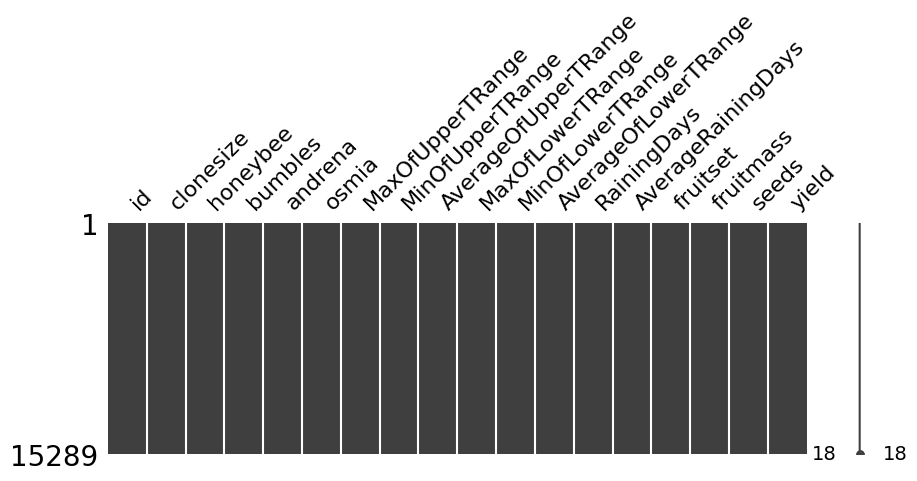

In [ ]:
msno.matrix(train_data, figsize=(10, 3))

### Checking For Proper Data Type

In [ ]:
train_data.dtypes

id                        int64
clonesize               float64
honeybee                float64
bumbles                 float64
andrena                 float64
osmia                   float64
MaxOfUpperTRange        float64
MinOfUpperTRange        float64
AverageOfUpperTRange    float64
MaxOfLowerTRange        float64
MinOfLowerTRange        float64
AverageOfLowerTRange    float64
RainingDays             float64
AverageRainingDays      float64
fruitset                float64
fruitmass               float64
seeds                   float64
yield                   float64
dtype: object

Let's figuring out what features are numerical or categorical. Beware that some integer-valued features could actually be categorical features, and some categorical features could be text features.

In [ ]:
numerical_features = train_data.select_dtypes(include=np.number).columns
print('Numerical columns:', numerical_features)

print('')

categorical_features = train_data.select_dtypes(include='object').columns
print('Categorical columns:', categorical_features)

Numerical columns: Index(['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

Categorical columns: Index([], dtype='object')


Seems like all features are numerical, and based on its values, we can confirm they have the proper data type. Let's move on to the next part.

### Identifing Outliers

There are a few values lying outside a normal range

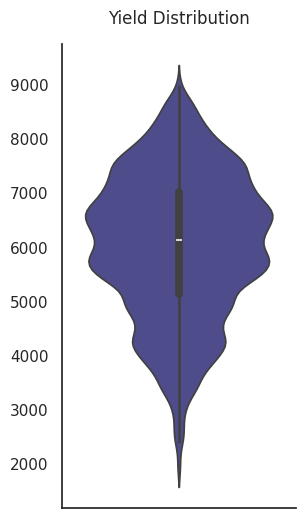

In [ ]:
g=sns.catplot(data=train_data, y='yield', kind='violin')
ChartWithCustomSettings(g, 3, 5, 'Yield Distribution')

Let's use Z-score to check if they are above the usual threshold level

In [ ]:
z= np.abs(stats.zscore(train_data['yield']))

outliers = len(np.where(z >= 3)[0])

print(f'There were found {outliers} outliers')

There were found 26 outliers


### Backup

In [ ]:
data_pre_processed = train_data.copy()

## Exploratory Data Analysis 📊

In this section we analized in three ways:
- General statistics of the dataset
- Visualizing Each Feature (Univariate Analysis)
- Visualizing multiple Features at the same time (Multivariate Analysis) and its correlation

### General View of the Dataset 🧮

In [ ]:
data_pre_processed.sample(5)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
11553,11553,25.0,0.50,0.25,0.50,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.466279,0.434133,34.660573,5329.26320
3198,3198,25.0,0.50,0.25,0.50,0.63,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.481329,0.438613,34.971315,5504.75083
8536,8536,25.0,0.50,0.25,0.63,0.50,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583698,0.494589,40.351186,5200.57849
15125,15125,12.5,0.25,0.25,0.63,0.63,69.7,42.1,58.2,50.2,24.3,41.2,16.0,0.26,0.467905,0.411272,33.221987,5807.00693
4824,4824,25.0,0.50,0.38,0.63,0.75,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.559215,0.476536,38.171597,7778.34916


In [ ]:
data_pre_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15289 non-null  int64  
 1   clonesize             15289 non-null  float64
 2   honeybee              15289 non-null  float64
 3   bumbles               15289 non-null  float64
 4   andrena               15289 non-null  float64
 5   osmia                 15289 non-null  float64
 6   MaxOfUpperTRange      15289 non-null  float64
 7   MinOfUpperTRange      15289 non-null  float64
 8   AverageOfUpperTRange  15289 non-null  float64
 9   MaxOfLowerTRange      15289 non-null  float64
 10  MinOfLowerTRange      15289 non-null  float64
 11  AverageOfLowerTRange  15289 non-null  float64
 12  RainingDays           15289 non-null  float64
 13  AverageRainingDays    15289 non-null  float64
 14  fruitset              15289 non-null  float64
 15  fruitmass          

In [ ]:
data_pre_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
id,15289.0,7644.000000,4413.698468,0.000000,3822.000000,7644.000000,11466.000000,15288.000000
clonesize,15289.0,19.704690,6.595211,10.000000,12.500000,25.000000,25.000000,40.000000
honeybee,15289.0,0.389314,0.361643,0.000000,0.250000,0.500000,0.500000,18.430000
bumbles,15289.0,0.286768,0.059917,0.000000,0.250000,0.250000,0.380000,0.585000
andrena,15289.0,0.492675,0.148115,0.000000,0.380000,0.500000,0.630000,0.750000
osmia,15289.0,0.592355,0.139489,0.000000,0.500000,0.630000,0.750000,0.750000
MaxOfUpperTRange,15289.0,82.169887,9.146703,69.700000,77.400000,86.000000,86.000000,94.600000
MinOfUpperTRange,15289.0,49.673281,5.546405,39.000000,46.800000,52.000000,52.000000,57.200000
AverageOfUpperTRange,15289.0,68.656256,7.641807,58.200000,64.700000,71.900000,71.900000,79.000000
MaxOfLowerTRange,15289.0,59.229538,6.610640,50.200000,55.800000,62.000000,62.000000,68.200000


In [ ]:
data_pre_processed.nunique()

id                      15289
clonesize                   6
honeybee                    7
bumbles                    11
andrena                    16
osmia                      14
MaxOfUpperTRange            6
MinOfUpperTRange            5
AverageOfUpperTRange        5
MaxOfLowerTRange            6
MinOfLowerTRange            7
AverageOfLowerTRange        5
RainingDays                 6
AverageRainingDays          8
fruitset                 1526
fruitmass                1515
seeds                    2066
yield                     776
dtype: int64

### Let's Analyze each Feature 💡
Univariate Analysis

We can observe that Yield (the target) has a slightly left-skewed distribution

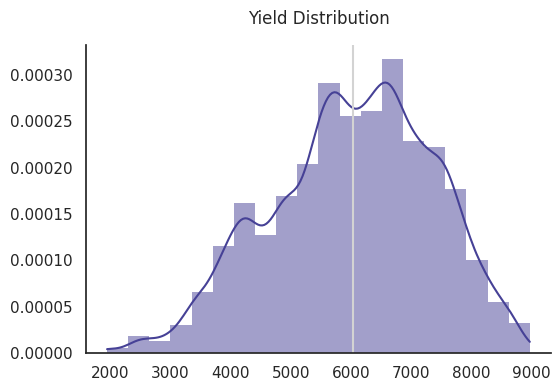

In [ ]:
g=sns.histplot(data_pre_processed['yield'], bins=20, kde=True, stat='density', linewidth=0)
ChartWithCustomSettings(g, 6, 4, 'Yield Distribution')
plt.xlabel('')

# Ploting the mean line
mean = data_pre_processed['yield'].mean()

plt.axvline(mean, 0, 1, color='lightgray', label='mean')

### How They Behave if We Put Them Together? 🤔
Bivariate Analysis

#### Numerical Predictors and Target

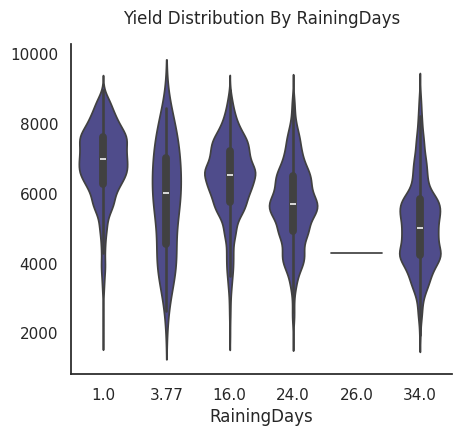

In [ ]:
g=sns.catplot(data=data_pre_processed, x='RainingDays', y='yield', estimator=np.mean, kind='violin')
ChartWithCustomSettings(g, 5, 4, 'Yield Distribution By RainingDays')

Now let's visualize the  correlation between each pair of variable.

As we can see, these  features `'MaxOfUpperTRange', 'MinOfLowerTRange', 'AverageRainingDays'` have high correlation almost or equal to 1. Let's leave them for now, but keep in mind that these can be removed to avoid adding complexity to the model.

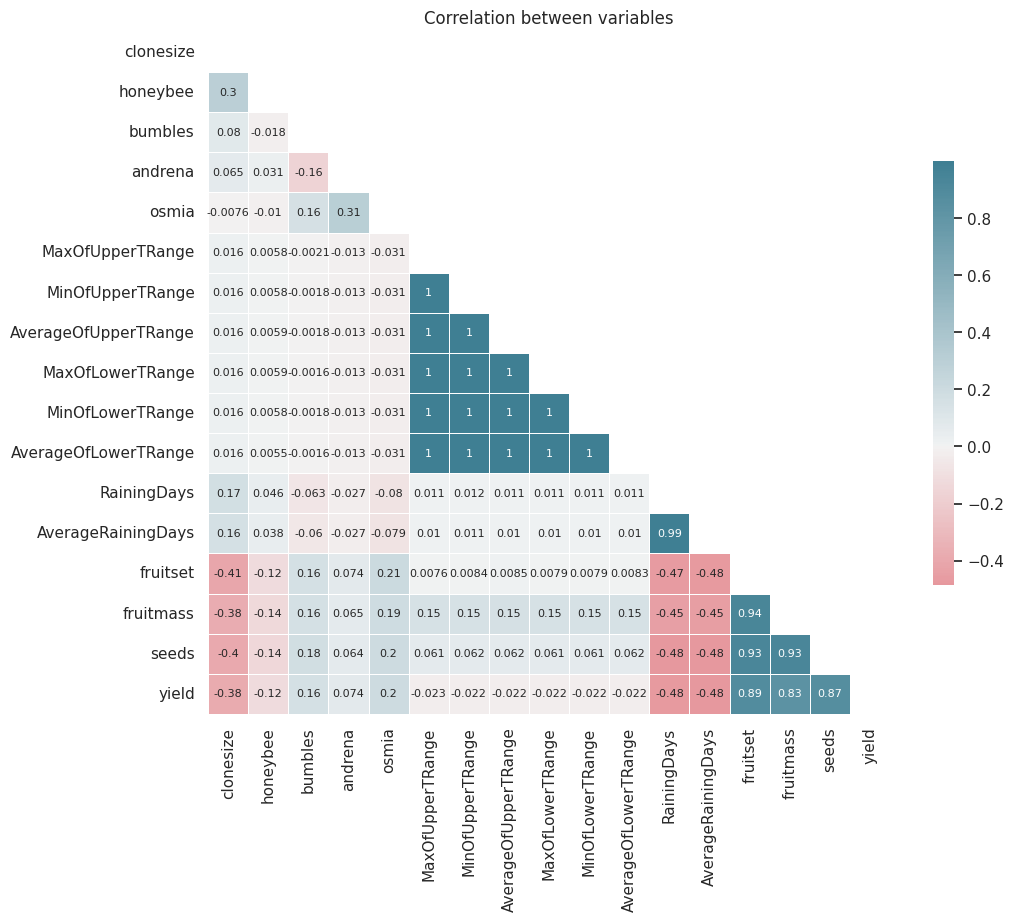

In [ ]:
# Calculate correlation between each pair of variable
corr = data_pre_processed.drop('id', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Inserir a figura
f, ax = plt.subplots(figsize=(11, 11))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask
ax = sns.heatmap(corr,
                 mask=mask,
                 cmap=cmap,
                 center=0,
                 annot=True,
                 annot_kws= {'size':8},
                 square=True,
                 xticklabels=True,
                 yticklabels=True,
                 linewidths=.5,
                 cbar_kws={'shrink': .5},
                 ax=ax
                )

ax.set_title('Correlation between variables', fontsize=12);

We can observe there is a positive correlation between Fruitset and Yield

Text(0, 0.5, 'Yield')

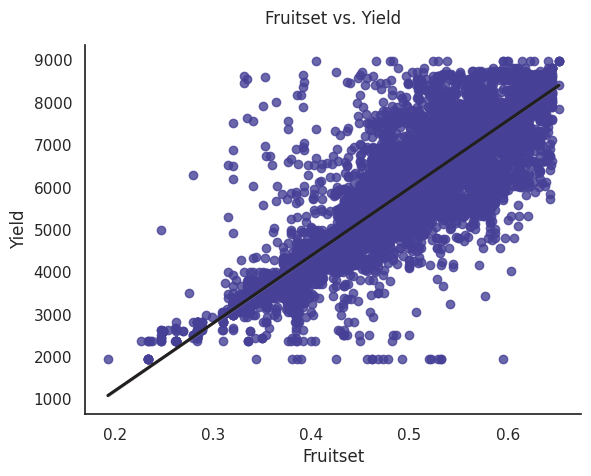

In [ ]:
sns.regplot(data=data_pre_processed, x='fruitset', y='yield', line_kws={'color': '#221f1f'})
ChartWithCustomSettings(g, 5, 4, 'Fruitset vs. Yield')
plt.xlabel('Fruitset')
plt.ylabel('Yield')

Now, let's find out what's the coefficient between fruitset and yield

In [ ]:
high_correlation_features = data_pre_processed[['seeds', 'fruitset', 'fruitmass']]
target_var = 'yield'

for col in high_correlation_features:
    coefficent, p_value = pearsonr(high_correlation_features[col], data_pre_processed[target_var])

# print(coefficent.round(3), p_value)
print(f"The correlation coefficient between {col} and {target_var} is {coefficent.round(3)} and the pvlaue is {p_value}")
print()

The correlation coefficient between fruitmass and yield is 0.826 and the pvlaue is 0.0



## Feature Transformation 🔪

Once we're done with EDA, we can start shaping the dataset ready to be used in the models

### Remove Unnecesary Columns

First, let's remember the dataset structure

In [ ]:
# Show a sample of the current dataset
data_pre_processed.sample(3)

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
9799,9799,12.5,0.25,0.25,0.75,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.567976,0.480779,39.646691,7163.94410
11565,11565,12.5,0.25,0.25,0.25,0.75,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.447781,0.424874,33.116091,5085.84473
11829,11829,25.0,0.50,0.25,0.38,0.75,86.0,52.0,71.9,62.0,30.0,50.8,34.0,0.56,0.462743,0.428118,33.441606,5772.91016


Everything but id column are okey. Let's remove it

In [ ]:
# Remove unnecesary columns
data_pre_processed.drop(columns=['id'], inplace=True)
data_pre_processed.head(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760


### Scaling Data
Standardize the dataset using Feature Scaling

As we see in the Distribution Charts, there are some values with high magnitude which could cause data leakage. So, to supress this effect, we need to normalize its range of all numerical features. This can be acheived by using **Feature Scaling**

But first, let's make a backup copy

In [ ]:
before_scaling_data = data_pre_processed.copy()
before_scaling_data.head(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760


Now we normalize the data by using StandardScaler(). We'll get all numerical features with proper magnitude.

In [ ]:
# Splitting the data
X_before_scaling = before_scaling_data.drop('yield', axis=1)

y = before_scaling_data['yield']

# Initialise the Scaler
scaler = StandardScaler()

# Scale the training dataset
X = scaler.fit_transform(X_before_scaling)

# Convert the NumPy array back to a Pandas DataFrame
X = pd.DataFrame(X, columns=X_before_scaling.columns)

X.head(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,0.802929,0.306073,-0.613664,1.737386,-0.662120,-1.363365,-1.365484,-1.368341,-1.365954,-1.364693,-1.366975,0.458012,0.401611,-1.044938,-0.783260,-0.918905
1,0.802929,0.306073,-0.613664,0.049454,-0.662120,-1.363365,-1.365484,-1.368341,-1.365954,-1.364693,-1.366975,0.458012,0.401611,-0.777454,-0.661588,-0.572230
2,-1.092448,-0.385238,-0.613664,0.927179,0.269883,0.418756,0.419514,0.424487,0.419105,0.419198,0.413979,0.458012,0.401611,0.674659,0.656157,0.540029


Last step of this process is splitting the data into train & test set to get  ready for fitting it to the models

In [ ]:
# Splitting the data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(12231, 16) (3058, 16)


## Building & Evaluating Model(s) 🤖👨‍🏫

### Building

Let's start by definning which machine learning models will be used

In [ ]:
# Dictionary of machine learning models that will be trained
models = {
            'Ridge': Ridge(),
            'LinearRegression': LinearRegression(),
            'SVR': SVR(),
            'DecisionTreeRegressor': DecisionTreeRegressor(),
            'RandomForestRegressor': RandomForestRegressor(),
            'XGBRegressor': XGBRegressor()
        }

Then we can create a function to fit and score models all at once

In [ ]:
# Create a fit_and_score function
def fit_and_score(models, X_train, X_test, y_train, y_test):

    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """

    # Random seed for reproducible results
    np.random.seed(42)

    # Make a list to keep model scores
    results = []

    # Loop through models
    for name, model in models.items():

        # Fit/Train the model to the data
        model.fit(X_train, y_train)

        # Make Predictions
        y_pred = model.predict(X_test)

        # Evaluate the model and append its score to model_scores
        R2_score = model.score(X_test, y_test) # By default it uses R2_score
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = mean_squared_error(y_test, y_pred, squared=False)

        # Add all metrics of model to a list
        results.append((name, R2_score, MSE, RMSE))

    return results

Let's call our function with all parameters needed

In [ ]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

Evaluating Models

Once the models are trained, we evaluate its performance using **R-Squared** which is the choosen metric for evaluating how good the model is at predicting Wild Blueberry Yield. But I also used Mean Squared Error & Root Mean Squared Error for comparison purpuses.

It seems like `RandomForestRegressor` is the best one, but let's try using `K-Fold cross-validation` just to make sure its accuracy is correct.


In [ ]:
# Dataframe with metrics of all trained models
results_df = pd.DataFrame(model_scores, columns = ['Model', 'R2_score', 'MSE', 'RMSE'])

# Add highlights in the dataframe to display best (green) and worst (red) performing models
results_format_df = results_df.style.highlight_max(subset = ['R2_score', 'RMSE'], color = 'green').highlight_min(subset = ['MSE'], color = 'green').highlight_max(subset = ['MSE'], color = 'red').highlight_min(subset = ['R2_score','RMSE'], color = 'red')

display(results_format_df)

,Model,R2_score,MSE,RMSE
0,Ridge,0.810383,333333.676304,577.350566
1,LinearRegression,0.810477,333169.787774,577.208617
2,SVR,0.501955,875531.280527,935.698285
3,DecisionTreeRegressor,0.635033,641589.017464,800.992520
4,RandomForestRegressor,0.812783,329114.664203,573.685161
5,XGBRegressor,0.806708,339795.291480,582.919627


### Evaluating Model Using K-Fold Cross Validation

> This method is used to estimate the skill of a machine learning model on unseen data. It will **evaluate the model multiple times** so you can be more confident about the model design. k value is how many samples the data will split. The choice of k is usually 5 or 10, being **10 the most common** in the field of applied machine learning, but there is no formal rule.

Utilizing K-Fold cross-validation, `Random Forest` still remains as the best model.

In [ ]:
# Make a list to keep model scores
results = []

# Loop through models
for name, model in models.items():

    # Fit/Train the model to the data
    model.fit(X_train, y_train)

    # Make Predictions
    y_pred = model.predict(X_test)

    # Evaluate the model and append its score to model_scores
    R2_score = model.score(X_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = mean_squared_error(y_test, y_pred, squared=False)

    # Add all metrics of model to a list
    results.append((name, R2_score, MSE, RMSE))

    print(name)
    kf = KFold(n_splits = 10, shuffle = True, random_state=42)
    scores = cross_val_score(model, X, y, cv = kf) # scoring="score" by default

    # Print out the Mean CV scores & Standard deviation for each model
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print('=' * 30)

Ridge
0.81 accuracy with a standard deviation of 0.01
LinearRegression
0.81 accuracy with a standard deviation of 0.01
SVR
0.54 accuracy with a standard deviation of 0.01
DecisionTreeRegressor
0.62 accuracy with a standard deviation of 0.02
RandomForestRegressor
0.81 accuracy with a standard deviation of 0.01
XGBRegressor
0.81 accuracy with a standard deviation of 0.02


Comparing Models

After doing k-fold validation, we could verify that `RandomForestRegressor` is the best model with an accuracy of 81% and a standard deviation of 1%.

In [ ]:
# Dataframe consisting of metrics of all the models
result_df = pd.DataFrame(results, columns = ['Model', 'R2_score', 'MSE', 'RMSE'])

# Add highlights in the dataframe to display best (green) and worst (red) performing models
result_format_df = result_df.style.highlight_max(subset = ['R2_score','RMSE'], color = 'green').highlight_min(subset = ['MSE'], color = 'green').highlight_max(subset = ['MSE'], color = 'red').highlight_min(subset = ['R2_score','RMSE'], color = 'red')

display(result_format_df)

,Model,R2_score,MSE,RMSE
0,Ridge,0.810383,333333.676304,577.350566
1,LinearRegression,0.810477,333169.787774,577.208617
2,SVR,0.501955,875531.280527,935.698285
3,DecisionTreeRegressor,0.618634,670417.767968,818.790430
4,RandomForestRegressor,0.811807,330831.068699,575.179162
5,XGBRegressor,0.806708,339795.291480,582.919627


## Hyperparameter Tuning

Now that we find out which model is the best for this scenario with the data we have, let's try tunning a bit more the models by using Hyperparameter Tuning throughout GridSearchCV.

> In this case we use **Grid Search** method to try several combinations. But, when the hyperparameter search space is large is a tedious task. So, instead we can use, **Randomized Search** It is an efficient method.

In [ ]:
model_params = [
    {'alpha': [0.1, 1.0, 10.0]},  # Ridge parameters
    {},  # LinearRegression doesn't require hyperparameters here
    {},  # SVR doesn't require hyperparameters here
    {},  # DecisionTreeRegressor doesn't require hyperparameters here
    {'n_estimators': [10, 50, 100]},  # RandomForestRegressor parameters
    {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}  # XGBRegressor parameters
]

Here, we performed Hyperparameter Tuning on multiple Regression Models to finally find out the best model

In [ ]:
scores = []
best_estimators = {}

for name, model, params in zip(models.keys(), models.values(), model_params):
    clf = GridSearchCV(model, params, cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

    best_estimators[model] = clf.best_estimator_

results = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
results

,model,best_score,best_params
0,Ridge,0.808868,{'alpha': 10.0}
1,LinearRegression,0.807210,{}
2,SVR,0.462866,{}
3,DecisionTreeRegressor,0.628891,{}
4,RandomForestRegressor,0.807681,{'n_estimators': 100}
5,XGBRegressor,0.819147,"{'learning_rate': 0.1, 'n_estimators': 50}"


Again, we train our model but now with the best hyperparameter previously found and get once again its scores of evaluation metrics.

In [ ]:
best_model=RandomForestRegressor(n_estimators=100)
best_model.fit(X_train,y_train)
y_pred=best_model.predict(X_test)

R2_score = model.score(X_test, y_test)
MSE = mean_squared_error(y_test, y_pred)
RMSE = mean_squared_error(y_test, y_pred, squared=False)

print("R2_score:", R2_score)
print("MSE:", MSE)
print("RMSE:", RMSE)

R2_score: 0.8067077856896194
MSE: 333042.17478148366
RMSE: 577.0980634012591


Here, we plotted the results of our best model (predicted), against the original results (actual).

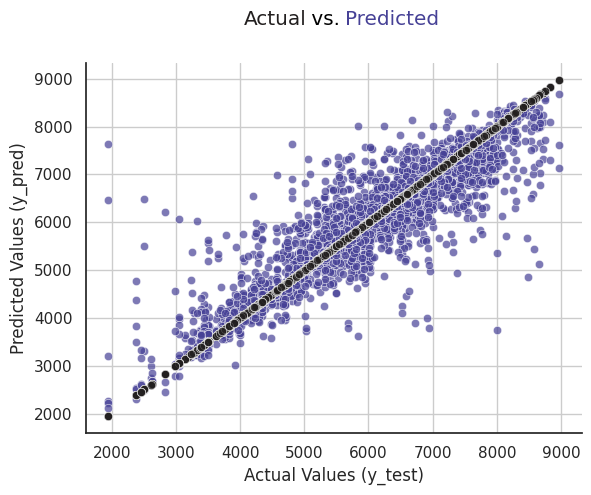

In [ ]:
# Show Actual vs. Predicted Values
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='#464196')
sns.scatterplot(x=y_test, y=y_test, alpha=0.7, color='#221f1f')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_pred)')
plt.figtext(0.47, 0.96, 'Actual', fontsize='large', color='#221f1f', ha ='right')
plt.figtext(0.53, 0.96, 'Predicted', fontsize='large', color='#464196', ha ='left')
plt.figtext(0.50, 0.96, ' vs. ', fontsize='large', color='k', ha ='center')
sns.despine()

plt.grid(True)

## Using the model with Unseen data

First, let's import the Unseen data

In [ ]:
# Loading unseen data
test_data = pd.read_csv('test.csv')

# Saving id of data
test_data_id = test_data['id']

# Remove unnecesary columns
test_data.drop(columns=['id'], inplace=True)
test_data.sample(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
3444,12.5,0.25,0.38,0.38,0.75,77.4,46.8,64.7,55.8,27.0,45.8,16.0,0.26,0.638323,0.527896,45.069192
3758,25.0,0.50,0.38,0.38,0.50,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.556302,0.472468,40.555019
2996,12.5,0.25,0.25,0.50,0.63,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.557251,0.480779,39.474324


Then, we nee to standarize it as we did with the training data

In [ ]:
# Scale the training dataset
X_test = scaler.fit_transform(test_data)

# Convert the NumPy array back to a Pandas DataFrame
X_test = pd.DataFrame(X_test, columns=test_data.columns)

X_test.head(3)

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,0.789503,-0.363088,-0.606503,-1.628845,-2.453506,0.414398,0.414768,0.420044,0.414636,0.414374,0.409109,0.466288,0.408256,-1.371318,-1.032509,-1.179639
1,-1.106867,-0.363088,-0.606503,1.745905,0.262907,1.353982,1.351365,1.348482,1.351655,1.352424,1.354337,-1.486257,-1.345772,-0.184207,-0.093898,0.176782
2,-1.106867,-0.363088,-0.606503,0.935965,0.262907,0.414398,0.414768,0.420044,0.414636,0.414374,0.409109,-0.212858,-0.378032,1.091922,1.098780,0.970547


Finally, we can predict on this new data and save the predictions as a csv file

In [ ]:
predictions = best_model.predict(X_test)

submission = pd.DataFrame({'id': test_data_id, 'yield': predictions})
submission.to_csv('RandomForestRegressor_submission.csv', index=False)

## Saving Model

A a last step, after developing the model, we need to save it for later uses.



In [ ]:
# Save the model in the 'model' directory
model_dir = "../model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, "random_forest.joblib")
joblib.dump(best_model, model_path)

If we want to verify that the model was saved we can load it and try it out on new data:

In [ ]:
# load, no need to initialize the loaded_rf
loaded_rf = joblib.load("./random_forest.joblib")

# Loading  new data
new_data = pd.read_csv('new_data.csv')

# Use it to verify its working
loaded_rf.predict(new_data)

## Results Explanation

The following chart shows you the `Feature importance` on this data. What I mean by that is what features were most important when it comes to predicting Wild Blueberries `Yield` (target variable).

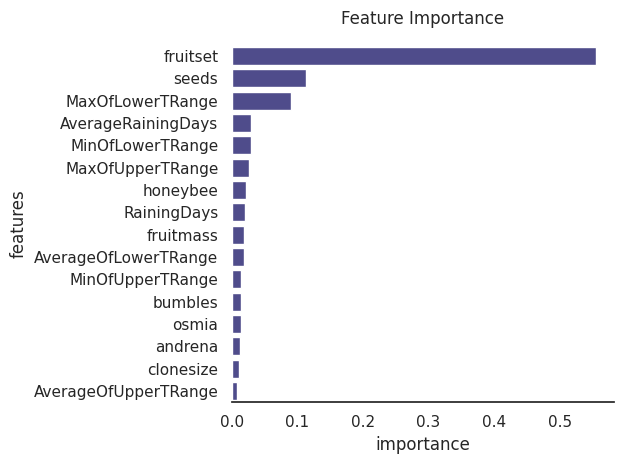

In [ ]:
# Getting feature importance
feat_importance= {'importance': model.feature_importances_, 'features': X.columns}

# Parsing it into a dataframe
df=pd.DataFrame.from_dict(feat_importance)
df.sort_values(ascending=False, by=['importance'], inplace=True)
df=df.dropna()

# Plotting Feature Importance with all features
sns.barplot(x='importance', y='features', data=df, orient='h')
ChartWithCustomSettings(g, 6, 4, 'Feature Importance')
sns.despine(left=True)
plt.tight_layout()

Getting only top 5 of the features by its importance in the model:

,importance,features
13,0.554793,fruitset
15,0.112663,seeds
8,0.090891,MaxOfLowerTRange
12,0.030018,AverageRainingDays
9,0.029331,MinOfLowerTRange


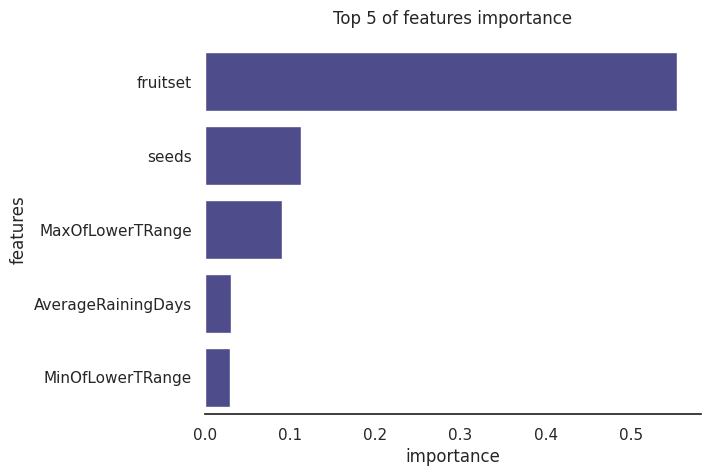

In [ ]:
# Parsing it into a dataframe
importance_df=pd.DataFrame.from_dict(feat_importance)
importance_df.sort_values(ascending=False, by=['importance'], inplace=True)
importance_df=importance_df.dropna()

# Getting only top 5 features
importance_df=importance_df.nlargest(5, 'importance')
display(importance_df)
print(' ')

# Plotting only top 5 features
sns.barplot(x='importance', y='features', data=importance_df, orient='h')
ChartWithCustomSettings(g, 6, 4, 'Top 5 of features importance')
sns.despine(left=True)

## Next Steps 🔜

There is always room for improvement, and for this project these are some things tha could be done to improve its predictiveness of the model:

- Better Feature Engineering
- Better experiments with Scaling
- Feature Encoding if we add some categorical data
- Better Model Tuning by playing a bit more with its hyperparameters
- Removing Features with High Correlation



---



You're Awesome 😍, you just reached the end of this post. If you have any questions just [drop me a message on my LikedIn](https://www.linkedin.com/in/enriquemosqueira/). Also, any suggestion or kudos would be quite appreciated. Did you find it useful? [Check out my other posts here](https://mrenrique.github.io/blog/), I'm sure you'll find something interesting 💡.

Share this post with your friends/colleagues, and if you are in a good mood, [buy me a cup of coffee ☕](https://www.buymeacoffee.com/enriquemr9X). Nos vemos! 🏃💨